In [3]:
#importing all the libraries
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
#move kaggle and set the permission

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)



In [6]:
#download the dataset

!kaggle datasets download -d fatemehmehrparvar/lung-disease



Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/34.9M [00:00<?, ?B/s]
100% 34.9M/34.9M [00:00<00:00, 1.27GB/s]


In [8]:
#extract the data

with zipfile.ZipFile("lung-disease.zip", 'r') as zip_ref:
    zip_ref.extractall("lung_disease_data")

print("Dataset unzipped.")


Dataset unzipped.


In [9]:
#checking folder structure

for root, dirs, files in os.walk("lung_disease_data"):
    print("Root:", root)
    print("Subdirectories:", dirs)
    break


Root: lung_disease_data
Subdirectories: ['Lung X-Ray Image']


In [10]:
#load the dataset
dataset_path = "lung_disease_data/Lung X-Ray Image/Lung X-Ray Image"


In [11]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)


Found 3475 files belonging to 3 classes.
Using 2780 files for training.
Found 3475 files belonging to 3 classes.
Using 695 files for validation.


In [12]:
class_names = train_ds.class_names
print("Class Labels:", class_names)


Class Labels: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


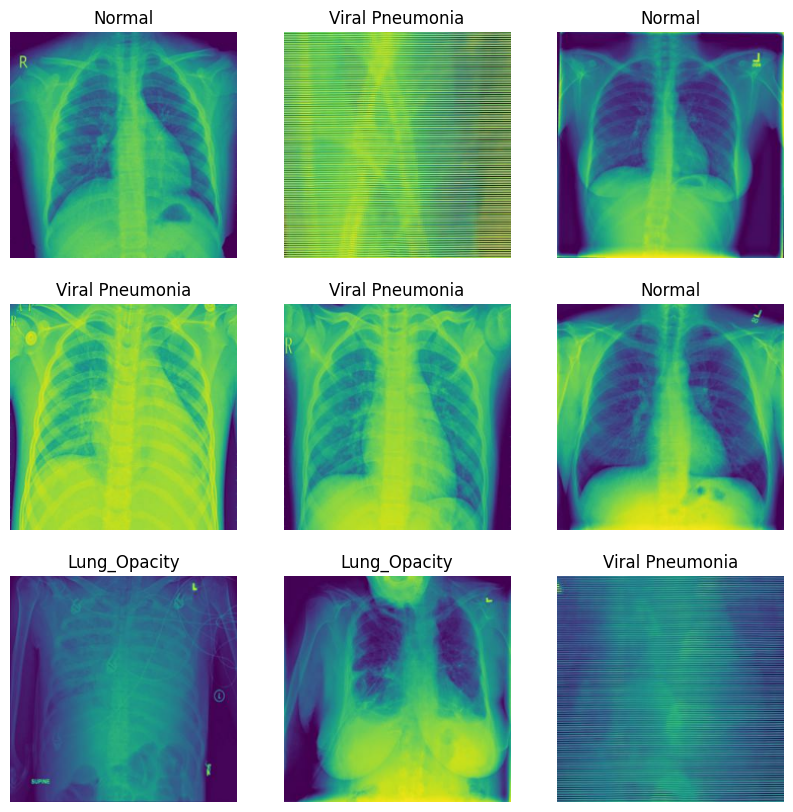

In [13]:
#visulize sample images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
#Model Training with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop])

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.7363 - loss: 1.2116 - val_accuracy: 0.6302 - val_loss: 0.7833
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8501 - loss: 0.4037 - val_accuracy: 0.7784 - val_loss: 0.4674
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8796 - loss: 0.3298 - val_accuracy: 0.8446 - val_loss: 0.3921
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8907 - loss: 0.2640 - val_accuracy: 0.8504 - val_loss: 0.4040
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9119 - loss: 0.2081 - val_accuracy: 0.8576 - val_loss: 0.3737
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9147 - loss: 0.2077 - val_accuracy: 0.8446 - val_loss: 0.4013
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9184 - loss: 0.1723 - val_accuracy: 0.8504 - val_loss: 0.3992
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9362 - loss: 0.1602 - val_accuracy: 0.8604

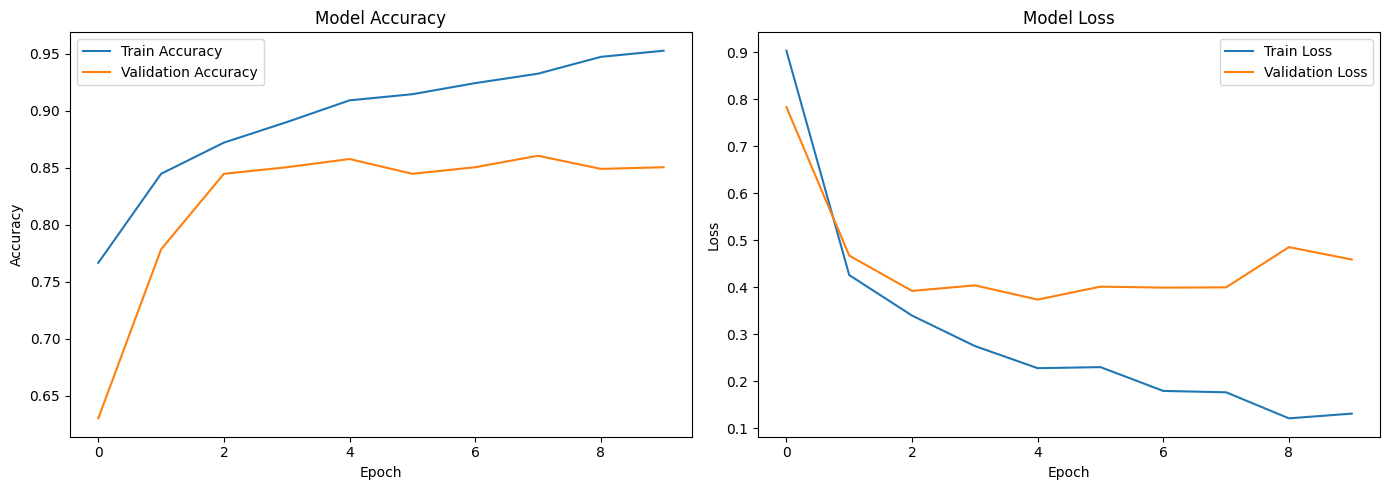

In [18]:
#Plot Accuracy and Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


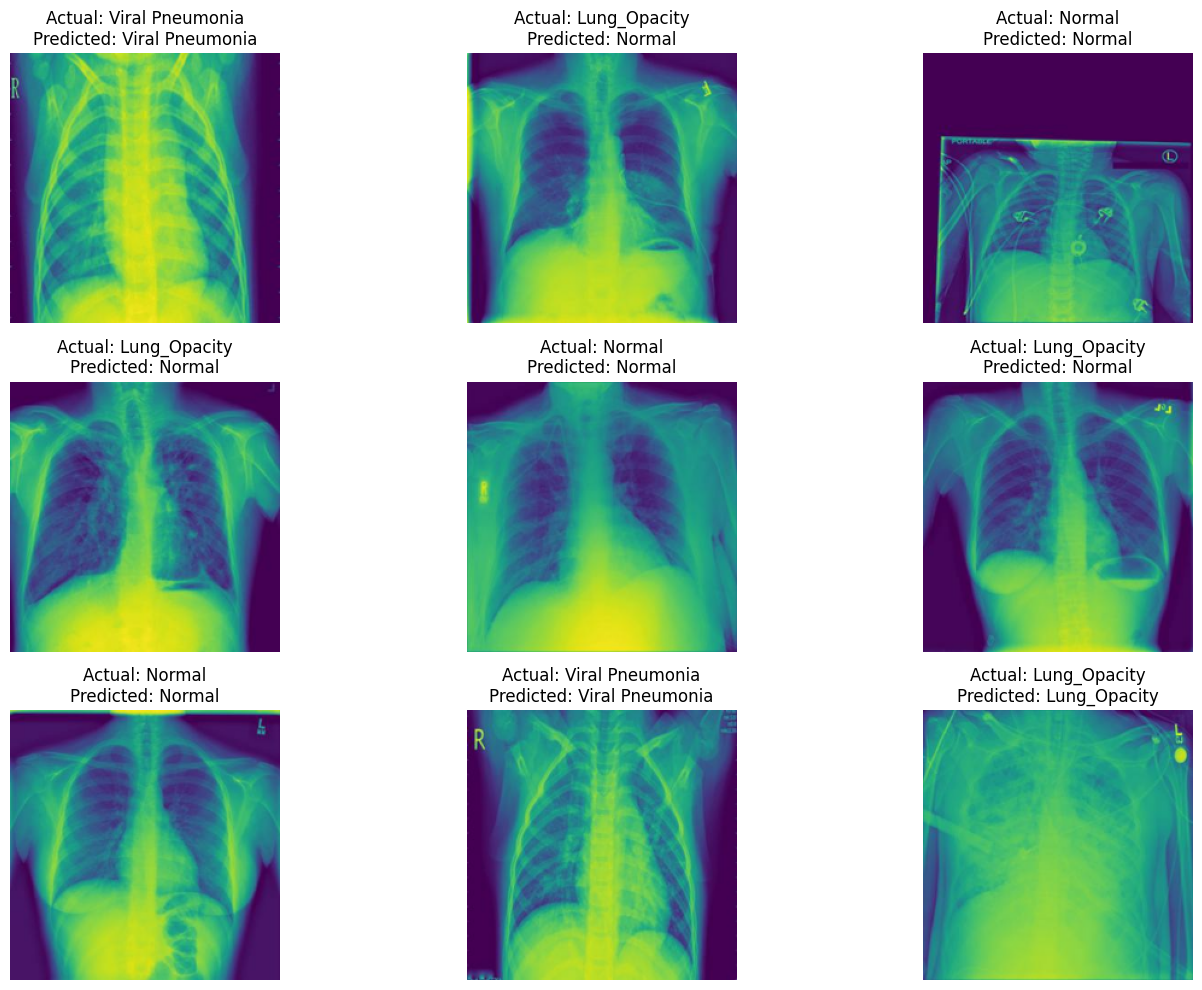

In [20]:
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    plt.figure(figsize=(15, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_label = class_names[true_classes[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


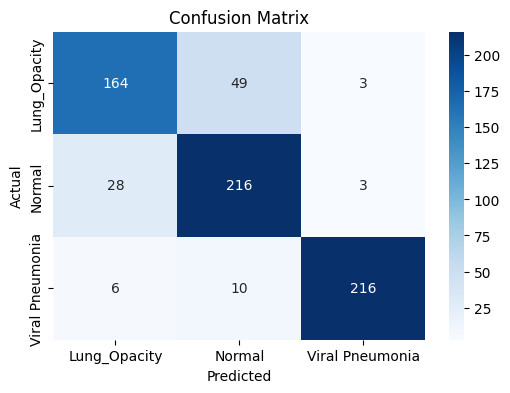

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity       0.83      0.76      0.79       216
         Normal       0.79      0.87      0.83       247
Viral Pneumonia       0.97      0.93      0.95       232

       accuracy                           0.86       695
      macro avg       0.86      0.85      0.86       695
   weighted avg       0.86      0.86      0.86       695



In [19]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
